<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name :  Bahar Dibaei Nia
### Student Number :  99105442
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [27]:
!pip install torchmetrics
from torchmetrics import F1Score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [17]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


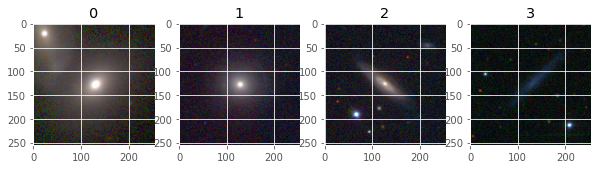

In [18]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
import PIL
visited=[False for i in range(4)]
fig, ax = plt.subplots(1, 4, figsize=(10,10))
for i in range(len(df)):
  if not(visited[df['class_label'][i]]):
    visited[df.iloc[i]['class_label']]=True
    image = PIL.Image.open('./efigi-1.6/png/'+df['name'][i]+'.png')
    ax[df.iloc[i]['class_label']].set_title(str(df.iloc[i]['class_label']))
    ax[df.iloc[i]['class_label']].imshow(image)
    if not(False in visited):
      break


            





# Define Dataset (20 Points)

In [19]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
import os
class GalaxyDataSet(Dataset):
    def __init__(self, df, img_dir='./efigi-1.6/png'):
        self.df=df
        self.img_dir=img_dir
        self.transforms=transforms.ToTensor()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        path=os.path.join(self.img_dir, self.df['name'][idx]+'.png')
        image=torch.flatten(self.transforms(PIL.Image.open(path)))
        label=self.df['class_label'][idx]
        return image, label

# Define Model (20 Points)

In [34]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self, input, n_class):
        super(ClassifierModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input, 256),
            #nn.BatchNorm1d(),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_class),
            nn.Softmax()
        )

    def forward(self, x):
        return self.network(x)

# Train Model (30 Points)

In [35]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
from torch.optim import SGD
import time
#dataloaders
data = GalaxyDataSet(df)
data_train, data_val, data_test = random_split(data, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=True)
test_loader = DataLoader(data_test, batch_size=32, shuffle=True)

#model
input = data_train[0][0].size()[0]
n_class = 4
model = ClassifierModel(input, n_class)

epochs = 40
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=8e-4)






In [36]:
from torchmetrics import ConfusionMatrix
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    #sc.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    all_labels=[]
    all_preds=[]
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            all_preds += preds
            all_labels+=labels
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    

    return epoch_loss, epoch_acc, torch.tensor(all_preds), torch.tensor(all_labels)

In [38]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
f1s= []
model = model.to(device)

# start the training
best_acc=0
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc, p, l = validate(model, val_loader,  
                                                criterion)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    f1 = F1Score(task="multiclass", num_classes=4)
    f=f1(p,l)

    f1s.append(f)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f} , f1score on valset: {f}")
   

# save the loss and accuracy plots
#save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 40
Training


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 98/98 [00:09<00:00, 10.09it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.38it/s]


Training loss: 0.978, training acc: 88.145
Validation loss: 1.112, validation acc: 74.738 , f1score on valset: 0.7473841309547424
[INFO]: Epoch 2 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


Training loss: 0.935, training acc: 91.798
Validation loss: 1.046, validation acc: 78.326 , f1score on valset: 0.7832586169242859
[INFO]: Epoch 3 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.17it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.34it/s]


Training loss: 0.896, training acc: 95.162
Validation loss: 1.023, validation acc: 78.774 , f1score on valset: 0.7877429127693176
[INFO]: Epoch 4 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.55it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


Training loss: 0.865, training acc: 96.956
Validation loss: 0.988, validation acc: 77.578 , f1score on valset: 0.7757847309112549
[INFO]: Epoch 5 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.40it/s]


Training loss: 0.845, training acc: 98.270
Validation loss: 1.002, validation acc: 78.924 , f1score on valset: 0.7892376780509949
[INFO]: Epoch 6 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.03it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.36it/s]


Training loss: 0.827, training acc: 98.718
Validation loss: 1.010, validation acc: 77.877 , f1score on valset: 0.7787742614746094
[INFO]: Epoch 7 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.06it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


Training loss: 0.814, training acc: 99.039
Validation loss: 0.981, validation acc: 78.027 , f1score on valset: 0.7802690863609314
[INFO]: Epoch 8 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.31it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


Training loss: 0.801, training acc: 99.359
Validation loss: 0.994, validation acc: 79.372 , f1score on valset: 0.7937219738960266
[INFO]: Epoch 9 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.23it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


Training loss: 0.794, training acc: 99.616
Validation loss: 0.995, validation acc: 79.821 , f1score on valset: 0.7982062697410583
[INFO]: Epoch 10 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.34it/s]


Training loss: 0.787, training acc: 99.712
Validation loss: 0.980, validation acc: 78.924 , f1score on valset: 0.7892376780509949
[INFO]: Epoch 11 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


Training loss: 0.782, training acc: 99.712
Validation loss: 0.986, validation acc: 79.970 , f1score on valset: 0.7997010350227356
[INFO]: Epoch 12 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


Training loss: 0.779, training acc: 99.776
Validation loss: 0.976, validation acc: 77.578 , f1score on valset: 0.7757847309112549
[INFO]: Epoch 13 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.61it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


Training loss: 0.777, training acc: 99.776
Validation loss: 0.974, validation acc: 78.625 , f1score on valset: 0.7862481474876404
[INFO]: Epoch 14 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.18it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


Training loss: 0.773, training acc: 99.840
Validation loss: 0.983, validation acc: 79.821 , f1score on valset: 0.7982062697410583
[INFO]: Epoch 15 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.18it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.38it/s]


Training loss: 0.772, training acc: 99.872
Validation loss: 0.970, validation acc: 78.625 , f1score on valset: 0.7862481474876404
[INFO]: Epoch 16 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.22it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


Training loss: 0.768, training acc: 99.968
Validation loss: 0.984, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 17 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.57it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  9.64it/s]


Training loss: 0.767, training acc: 99.936
Validation loss: 0.986, validation acc: 79.821 , f1score on valset: 0.7982062697410583
[INFO]: Epoch 18 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


Training loss: 0.765, training acc: 99.968
Validation loss: 0.983, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 19 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.11it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


Training loss: 0.763, training acc: 99.968
Validation loss: 0.980, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 20 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.32it/s]


Training loss: 0.762, training acc: 99.968
Validation loss: 0.986, validation acc: 78.774 , f1score on valset: 0.7877429127693176
[INFO]: Epoch 21 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


Training loss: 0.761, training acc: 99.968
Validation loss: 0.979, validation acc: 79.223 , f1score on valset: 0.7922272086143494
[INFO]: Epoch 22 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


Training loss: 0.761, training acc: 99.968
Validation loss: 0.973, validation acc: 78.475 , f1score on valset: 0.7847533822059631
[INFO]: Epoch 23 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.09it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.35it/s]


Training loss: 0.759, training acc: 100.000
Validation loss: 0.982, validation acc: 79.372 , f1score on valset: 0.7937219738960266
[INFO]: Epoch 24 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.24it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.30it/s]


Training loss: 0.759, training acc: 100.000
Validation loss: 0.982, validation acc: 78.774 , f1score on valset: 0.7877429127693176
[INFO]: Epoch 25 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.14it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.43it/s]


Training loss: 0.758, training acc: 100.000
Validation loss: 0.976, validation acc: 79.522 , f1score on valset: 0.7952167391777039
[INFO]: Epoch 26 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.03it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  8.20it/s]


Training loss: 0.758, training acc: 100.000
Validation loss: 0.975, validation acc: 79.671 , f1score on valset: 0.7967115044593811
[INFO]: Epoch 27 of 40
Training


100%|██████████| 98/98 [00:09<00:00,  9.82it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.35it/s]


Training loss: 0.757, training acc: 100.000
Validation loss: 0.976, validation acc: 79.522 , f1score on valset: 0.7952167391777039
[INFO]: Epoch 28 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


Training loss: 0.756, training acc: 100.000
Validation loss: 0.975, validation acc: 79.223 , f1score on valset: 0.7922272086143494
[INFO]: Epoch 29 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.19it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


Training loss: 0.755, training acc: 100.000
Validation loss: 0.977, validation acc: 78.924 , f1score on valset: 0.7892376780509949
[INFO]: Epoch 30 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


Training loss: 0.755, training acc: 100.000
Validation loss: 0.984, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 31 of 40
Training


100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  8.36it/s]


Training loss: 0.755, training acc: 100.000
Validation loss: 0.979, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 32 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.17it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


Training loss: 0.755, training acc: 100.000
Validation loss: 0.975, validation acc: 79.372 , f1score on valset: 0.7937219738960266
[INFO]: Epoch 33 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.21it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.38it/s]


Training loss: 0.754, training acc: 100.000
Validation loss: 0.978, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 34 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.31it/s]


Training loss: 0.754, training acc: 100.000
Validation loss: 0.978, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 35 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.06it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  8.95it/s]


Training loss: 0.754, training acc: 100.000
Validation loss: 0.970, validation acc: 78.774 , f1score on valset: 0.7877429127693176
[INFO]: Epoch 36 of 40
Training


100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.39it/s]


Training loss: 0.753, training acc: 100.000
Validation loss: 0.971, validation acc: 78.924 , f1score on valset: 0.7892376780509949
[INFO]: Epoch 37 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.20it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


Training loss: 0.753, training acc: 100.000
Validation loss: 0.971, validation acc: 78.027 , f1score on valset: 0.7802690863609314
[INFO]: Epoch 38 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.14it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.44it/s]


Training loss: 0.753, training acc: 100.000
Validation loss: 0.975, validation acc: 79.073 , f1score on valset: 0.7907324433326721
[INFO]: Epoch 39 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.28it/s]


Validation


100%|██████████| 21/21 [00:02<00:00, 10.34it/s]


Training loss: 0.753, training acc: 100.000
Validation loss: 0.979, validation acc: 78.924 , f1score on valset: 0.7892376780509949
[INFO]: Epoch 40 of 40
Training


100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Validation


100%|██████████| 21/21 [00:02<00:00,  8.09it/s]

Training loss: 0.752, training acc: 100.000
Validation loss: 0.972, validation acc: 78.924 , f1score on valset: 0.7892376780509949
TRAINING COMPLETE


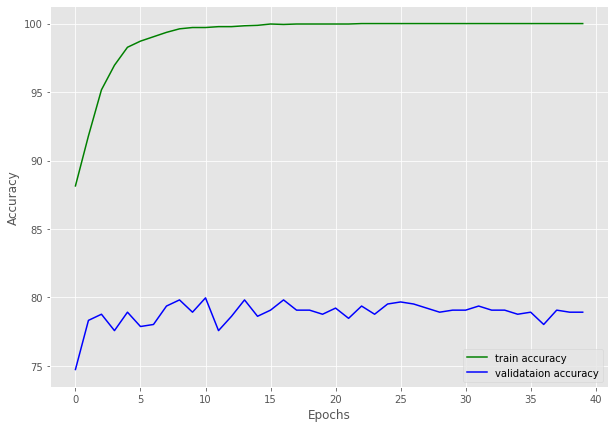

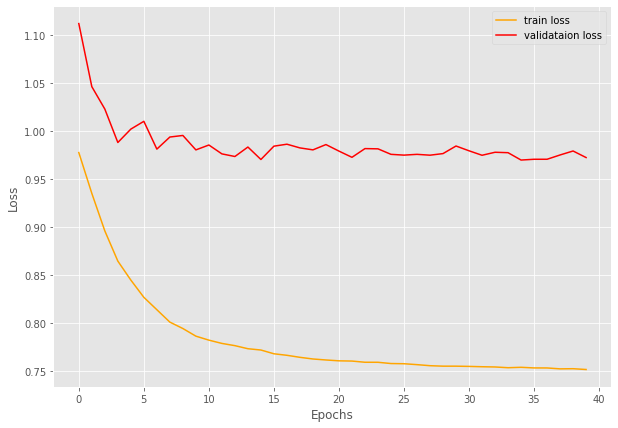

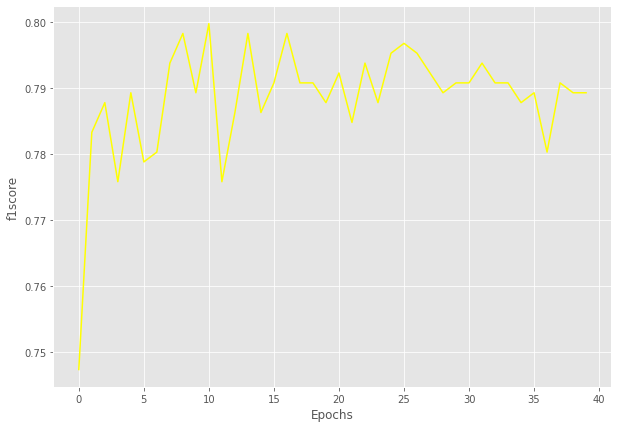

In [39]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

 # accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    # loss plots
plt.figure(figsize=(10, 7))
plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#f1 plot
plt.figure(figsize=(10, 7))
plt.plot(
        f1s, color='yellow', linestyle='-', 
        label='train loss'
    )
plt.xlabel('Epochs')
plt.ylabel('f1score')
plt.show()



# Test Model (20)

Validation


  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


loss: 0.9708100018047151
acc: 79.79041916167665
f1-score: tensor(0.7979)
confusion matrix: [[ 20  19   5   0]
 [ 11  31  35   0]
 [  4  10 477   0]
 [  2   0  49   5]]


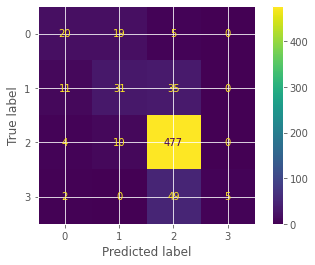

In [45]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
test_epoch_loss, test_epoch_acc, p, l = validate(model, test_loader,  
                                                criterion)
f1=F1Score(task="multiclass", num_classes=4)
f=f1(p,l)
mat=confusion_matrix(l,p)
print('loss:',test_epoch_loss)
print('acc:',test_epoch_acc)
print('f1-score:',f)
print('confusion matrix:',mat)

disp=ConfusionMatrixDisplay(mat)
disp.plot()
plt.show()



